# Milestone 5 - Database/Visualizing Data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from bs4 import BeautifulSoup
import requests
import http.client
import urllib.error
import json
import seaborn as sns

## Load Data

The following includes code from previous milestones that were needed to have a clean dataset for this milestone.

### CSV: Fortune 1000

In [8]:
# Read in csv file from Kaggle
# https://www.kaggle.com/datasets/ramjasmaurya/fortune-1000-companieslatest?select=fortune+1000+companies+in+dec2021.csv
fortune_comp = pd.read_csv('data/fortune_1000_companies.csv',index_col=0)

In [9]:
new_column_headers = {'Rank': 'rank',
                      'Name': 'name',
                      'Revenue': 'rev',
                      'revenue(% change)': 'rev_change',
                      'profits in millions': 'profit',
                      'profits % change': 'profit_change',
                      'market value': 'market',
                      'change in rank in 1000': 'rank_change_1000',
                      'employees': 'emp',
                      'change in rank(500 only)':'rank_change_500',
                      'measure_up_rank': 'rank_measure'}

In [10]:
# Rename columns based on list above and replace
fortune_comp.rename(columns=new_column_headers, inplace=True)

In [11]:
# For each column that is an object
for x in fortune_comp.iloc[:, np.r_[2:9,10:12]]: 
    # Check if contains - character
    if(fortune_comp[x].str.contains('-').values.any()):
        # Replace with 0
        fortune_comp.loc[(fortune_comp[x] == "-"),x] = "0"

In [12]:
# Remove currency format from columns
def clean_currency(x):
    return(x.replace('$', '').replace(',', ''))

In [13]:
# apply clean currency function on columns with currency formatting
for x in fortune_comp.iloc[:, np.r_[2,4,6:8]]: 
    fortune_comp[x] = fortune_comp[x].apply(clean_currency)

In [14]:
# Change associated columns to float when currency or requires decimal
for x in fortune_comp.iloc[:, np.r_[2:8]]: 
    fortune_comp[x] = fortune_comp[x].astype(float)

In [15]:
# Change ranks to int
for x in fortune_comp.iloc[:, np.r_[8:12]]: 
    fortune_comp[x] = fortune_comp[x].astype(int)

In [10]:
# 12 columns, 1000 rows
# No change of number of records
fortune_comp.shape

(1000, 12)

In [16]:
# First 10 records
fortune_comp.head()

,rank,name,rev,rev_change,profit,profit_change,assets,market,rank_change_1000,emp,rank_change_500,rank_measure
0,1,Walmart,559151.0,0.067,13510.0,-0.092,252496.0,382642.8,0,2300000,0,20
1,2,Amazon,386064.0,0.376,21331.0,0.841,321195.0,1558069.6,0,1298000,0,11
2,3,Apple,274515.0,0.055,57411.0,0.039,323888.0,2050665.9,1,147000,1,188
3,4,CVS Health,268706.0,0.046,7179.0,0.082,230715.0,98653.2,1,256500,1,57
4,5,UnitedHealth Group,257141.0,0.062,15403.0,0.113,197289.0,351725.0,2,330000,2,25


### Website: List of S&P 500 Companies

In [12]:
# Get html page
html_document = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#:~:text=S%26P%20500%20component%20stocks%20%20%20%20Symbol,%20%20%20%2014%20more%20rows%20')

In [13]:
# Pares through Beautiful Soup
soup = BeautifulSoup(html_document.text, 'html.parser')

In [14]:
# the table has id of constituents
table = soup.find_all('table', {'id':'constituents'})

In [15]:
# Get headers of table
headers = [th.getText().strip() for th in table[0].findAll('th')]

In [16]:
# Get rows by getting all tr in tbody
rows = table[0].findAll('tr')[1:]
    
# get text from row in each cell
row_data = [[td.text.strip() for td in tr.findAll('td')] for tr in rows]

In [17]:
# Create dataframe with header and row text
sp_table = pd.DataFrame(row_data, columns=headers)

In [18]:
new_column_headers = {'Symbol': 'symbol',
                      'Security': 'security',
                      'GICS Sector': 'gics_sec',
                      'GICS Sub-Industry': 'gics_sub',
                      'Headquarters Location': 'headquarters',
                      'Date added': 'sp_date',
                      'CIK': 'cik',
                      'Founded':'founded'}

In [19]:
# Rename columns based on list above and replace
sp_table.rename(columns=new_column_headers, inplace=True)
sp_table.head()

,symbol,security,gics_sec,gics_sub,headquarters,sp_date,cik,founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,0000066740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989


In [20]:
# Split founded year to only use the first entered year
sp_table['founded'] = sp_table['founded'].str.split('(').str[0]
sp_table['founded'] = sp_table['founded'].str.split('/').str[0]

In [21]:
# Convert from object to int
sp_table['founded'] = sp_table['founded'].astype(int)

In [22]:
# Split date added for first date entered
sp_table['sp_date'] = sp_table['sp_date'].str.split('(').str[0]
sp_table['sp_date'] = sp_table['sp_date'].str.replace('[<,?]', '')

C:\Users\jcamp\AppData\Local\Temp\ipykernel_18560\418126011.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  sp_table['sp_date'] = sp_table['sp_date'].str.replace('[<,?]', '')


In [23]:
# Convert to datetime
sp_table['sp_date'] = pd.to_datetime(sp_table['sp_date'])

In [24]:
# Drop duplicates
# Kept Class A records
sp_table.drop_duplicates(subset='cik', inplace=True)

In [25]:
sp_table['cik'] = sp_table['cik'].astype(int)

In [26]:
# Seperate city and state/province for headquarters
# Use first entry
sp_table['hq_city'] = sp_table['headquarters'].str.split(',', expand = True)[0]
sp_table['hq_state_prov'] = sp_table['headquarters'].str.split(',', expand = True)[1]

In [27]:
# Drop original headquarters
sp_table.drop(['headquarters'], axis=1, inplace=True)

In [28]:
sp_table.shape

(500, 9)

In [29]:
sp_table.head()

,symbol,security,gics_sec,gics_sub,sp_date,cik,founded,hq_city,hq_state_prov
0,MMM,3M,Industrials,Industrial Conglomerates,1976-08-09,66740,1902,Saint Paul,Minnesota
1,AOS,A. O. Smith,Industrials,Building Products,2017-07-26,91142,1916,Milwaukee,Wisconsin
2,ABT,Abbott,Health Care,Health Care Equipment,1964-03-31,1800,1888,North Chicago,Illinois
3,ABBV,AbbVie,Health Care,Pharmaceuticals,2012-12-31,1551152,2013,North Chicago,Illinois
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,2011-07-06,1467373,1989,Dublin,Ireland


### API: Marketstack Historical Data

In [30]:
# Get access key
with open('MarketStackAPIkeys.json') as f:
    key = json.load(f)
    access_key = key['access_key']

In [31]:
# Get individual stock data
def getStockData(frames, ticker):
    try:    
        # Connect to Marketstack API
        conn = http.client.HTTPConnection("api.marketstack.com")
        # Pull data by stock ticker from the end of December 2021
        conn.request("GET", "/v1/eod?access_key=" + access_key + "&symbols="+ ticker +"&%20date_from=2021-12-31&date_to=2021-12-31")

        # read and parse response
        res = conn.getresponse()
        data = res.read()
        stock = json.loads(data)

        # if valid, parse and add data to df
        if(res.status == 200):
            stock_df = pd.DataFrame(stock['data'])
            frames.append(stock_df)
        else:
            print("Error: ",stock['Error'])

    # print any URL error
    except urllib.error.URLError as e:
        print(e)
        print("ERROR: {}".format(e.reason))    

In [32]:
# Find and combine all stock data
def createDF(tickers):
    frames = []
    # for each ticker in list
    for t in tickers:
        # Find associated stock data
        getStockData(frames, t)
    # add all calls to one dataframe
    stock_df = pd.concat(frames)
    return stock_df

In [ ]:
# Grab data through API call
stock_df = createDF(list(sp_table.symbol))
# Reset index
stock_df.reset_index(inplace = True)

In [49]:
# For the main stock measurements
for i in stock_df.iloc[:, 1:5]:
    count = 0
    # for each of the adjusted measurements
    for a in stock_df.iloc[:, 5:10]:
        # Check if adjusted matches main name
        if i in a:
            # For each value in adjusted
            for index, value in stock_df[a].iteritems():
                # Check not null
                if pd.notna(value):
                    # Replace main value with adjusted
                    stock_df[i].loc[index] = value
                    count += 1

C:\Users\jcamp\AppData\Local\Temp\ipykernel_18560\701533649.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df[i].loc[index] = value


In [50]:
# Drop all columns with adjusted values, split factor, and dividends
stock_df.drop(stock_df.columns[5:12], axis=1, inplace=True)

In [51]:
stockr_df = stock_df.reindex(columns= ['symbol', 'open', 'high', 'low', 'close', 'volume', 'exchange', 'date'])

In [52]:
stockr_df['date'] = pd.to_datetime(stockr_df['date'])
stockr_df['date'] = stockr_df['date'].dt.date

In [53]:
# Outlier found for GOOG
# Copy high, low, and close from GOOGL affiliated stock as reference point
stockr_df.at[23,'high'] = stockr_df.at[22,'high']
stockr_df.at[23,'low'] = stockr_df.at[22,'low']
stockr_df.at[23,'close'] = stockr_df.at[22,'close']

In [54]:
stockr_df['diff'] = stockr_df['close'] - stockr_df['open']

In [55]:
stockr_df.head()

,symbol,open,high,low,close,volume,exchange,date,diff
0,MMM,177.53,178.35,176.5100,177.63,1414600.0,XNYS,2021-12-31,0.10
1,AOS,85.13,86.25,85.1300,85.85,966600.0,XNYS,2021-12-31,0.72
2,ABT,141.00,141.77,140.7200,140.74,3271000.0,XNYS,2021-12-31,-0.26
3,ABBV,136.04,136.21,135.3000,135.40,3962700.0,XNYS,2021-12-31,-0.64
4,ACN,412.70,416.95,412.1096,414.55,1163448.0,XNYS,2021-12-31,1.85


## Create Database

In [2]:
# Import libararies
import sqlite3

In [5]:
# Function to check connection
def connectionStatus(conn):
    try:
        conn.execute("SELECT * FROM sp500 LIMIT 1")
        return True
    except sqlite3.ProgrammingError as e:
        print("No connection. Error: {}".format(e))
        return False

In [3]:
conn = sqlite3.connect('sp500index.db')

In [7]:
connectionStatus(conn)

True

In [4]:
c = conn.cursor()

### Fortune 1000 Table

In [17]:
fortune_comp.to_sql("fortune1000", conn, if_exists="replace")

1000

In [18]:
pd.read_sql('SELECT * FROM fortune1000 LIMIT 5',conn)

,index,rank,name,rev,rev_change,profit,profit_change,assets,market,rank_change_1000,emp,rank_change_500,rank_measure
0,0,1,Walmart,559151.0,0.067,13510.0,-0.092,252496.0,382642.8,0,2300000,0,20
1,1,2,Amazon,386064.0,0.376,21331.0,0.841,321195.0,1558069.6,0,1298000,0,11
2,2,3,Apple,274515.0,0.055,57411.0,0.039,323888.0,2050665.9,1,147000,1,188
3,3,4,CVS Health,268706.0,0.046,7179.0,0.082,230715.0,98653.2,1,256500,1,57
4,4,5,UnitedHealth Group,257141.0,0.062,15403.0,0.113,197289.0,351725.0,2,330000,2,25


### S&P 500 Table

In [39]:
sp_table.to_sql("sp500", conn, if_exists="replace")

500

In [19]:
pd.read_sql('SELECT * FROM sp500 LIMIT 5',conn)

,index,symbol,security,gics_sec,gics_sub,sp_date,cik,founded,hq_city,hq_state_prov
0,0,MMM,3M,Industrials,Industrial Conglomerates,1976-08-09 00:00:00,66740,1902,Saint Paul,Minnesota
1,1,AOS,A. O. Smith,Industrials,Building Products,2017-07-26 00:00:00,91142,1916,Milwaukee,Wisconsin
2,2,ABT,Abbott,Health Care,Health Care Equipment,1964-03-31 00:00:00,1800,1888,North Chicago,Illinois
3,3,ABBV,AbbVie,Health Care,Pharmaceuticals,2012-12-31 00:00:00,1551152,2013,North Chicago,Illinois
4,4,ACN,Accenture,Information Technology,IT Consulting & Other Services,2011-07-06 00:00:00,1467373,1989,Dublin,Ireland


### Stock Value

In [56]:
stockr_df.to_sql("stock_value", conn, if_exists="replace")

493

In [20]:
pd.read_sql('SELECT * FROM stock_value LIMIT 5',conn)

,index,symbol,open,high,low,close,volume,exchange,date,diff
0,0,MMM,177.53,178.35,176.5100,177.63,1414600.0,XNYS,2021-12-31,0.10
1,1,AOS,85.13,86.25,85.1300,85.85,966600.0,XNYS,2021-12-31,0.72
2,2,ABT,141.00,141.77,140.7200,140.74,3271000.0,XNYS,2021-12-31,-0.26
3,3,ABBV,136.04,136.21,135.3000,135.40,3962700.0,XNYS,2021-12-31,-0.64
4,4,ACN,412.70,416.95,412.1096,414.55,1163448.0,XNYS,2021-12-31,1.85


### Merged Dataset

In [85]:
# Create SQL Table with all 3 datasets joined
# Organized table in format that made sense
c.execute("""CREATE TABLE sp_merged AS SELECT sp500.symbol, sp500.security, sp500.gics_sec, sp500.gics_sub, sp500.sp_date, 
             sp500.cik, sp500.founded, sp500.hq_city, sp500.hq_state_prov, fortune1000.rank, fortune1000.rev,
             fortune1000.rev_change, fortune1000.profit, fortune1000.profit_change, fortune1000.assets, fortune1000.market,
             fortune1000.rank_change_1000, fortune1000.emp, fortune1000.rank_change_500, fortune1000.rank_measure,
             stock_value.open, stock_value.high, stock_value.low, stock_value.close, stock_value.diff, stock_value.volume, 
             stock_value.exchange, stock_value.date AS 'stock_date'
             FROM fortune1000
             RIGHT JOIN sp500 ON fortune1000.name = sp500.security
             LEFT JOIN stock_value ON sp500.symbol = stock_value.symbol""")

In [86]:
# Validate table
pd.read_sql('SELECT * FROM sp_merged LIMIT 5',conn)

,symbol,security,gics_sec,gics_sub,sp_date,cik,founded,hq_city,hq_state_prov,rank,...,rank_change_500,rank_measure,open,high,low,close,diff,volume,exchange,stock_date
0,WMT,Walmart,Consumer Staples,Hypermarkets & Super Centers,1982-08-31 00:00:00,104169,1962,Bentonville,Arkansas,1,...,0,20,143.2000,145.04,142.9200,144.6900,1.49,5982000.0,XNYS,2021-12-31
1,AMZN,Amazon,Consumer Discretionary,Internet & Direct Marketing Retail,2005-11-18 00:00:00,1018724,1994,Seattle,Washington,2,...,0,11,3379.1201,3387.00,3331.1699,3334.3401,-44.78,2387300.0,XNAS,2021-12-31
2,CVS,CVS Health,Health Care,Health Care Services,1957-03-04 00:00:00,64803,1996,Woonsocket,Rhode Island,4,...,1,57,103.4800,103.76,103.1300,103.1600,-0.32,3251200.0,XNYS,2021-12-31
3,UNH,UnitedHealth Group,Health Care,Managed Health Care,1994-07-01 00:00:00,731766,1977,Minnetonka,Minnesota,5,...,2,25,504.1400,506.87,502.0400,502.1400,-2.00,1695000.0,XNYS,2021-12-31
4,BRK.B,Berkshire Hathaway,Financials,Multi-Sector Holdings,2010-02-16 00:00:00,1067983,1839,Omaha,Nebraska,6,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [5]:
# Import into Python Dataframe
sp500_df = pd.read_sql('SELECT * FROM sp_merged',conn)

## Visualizations

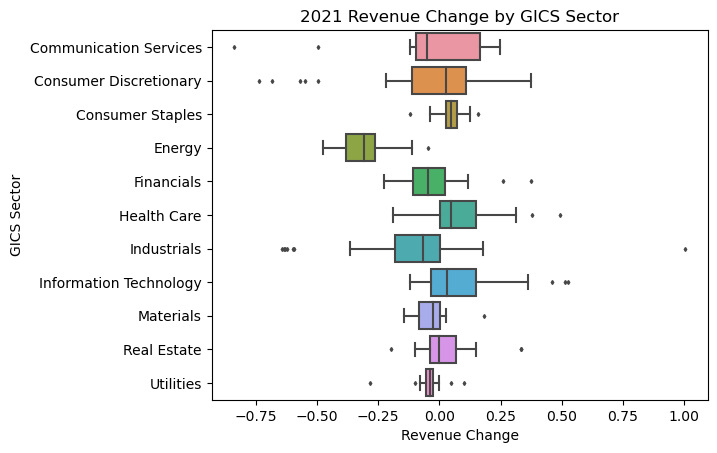

In [48]:
# Sort by GICS Sector
sp500_gs = sp500_df.sort_values("gics_sec")
# Boxplot of revenue change for eac GICS Sector
rc = sns.boxplot(data=sp500_gs, x="rev_change", y="gics_sec",  fliersize=2)
rc.set(title="2021 Revenue Change by GICS Sector", xlabel='Revenue Change', ylabel='GICS Sector')
plt.show()

In [9]:
# Create Tricennial for Founded Date
sp500_df['triennial'] = sp500_df['founded'] - sp500_df['founded'] % 30
# Group by decade and get mean with reset index
sp500_triennial = sp500_df.groupby(sp500_df.triennial).mean().reset_index()
# Convert decade to int
sp500_triennial['triennial'] = sp500_triennial['triennial'].dropna().astype(int)

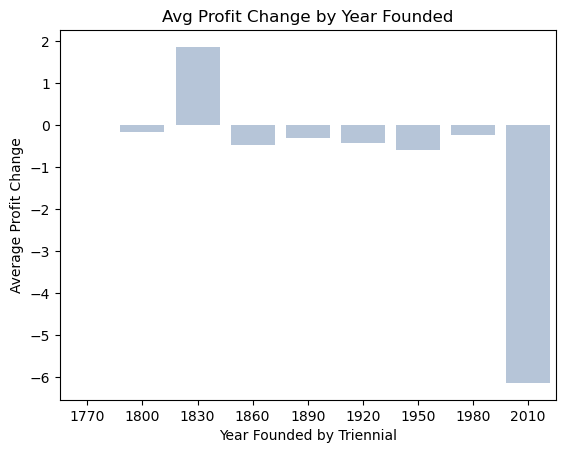

In [10]:
# Avg Profit Change by S&P 500 Company Year Founded
dp = sns.barplot(data=sp500_triennial, x="triennial", y="profit_change", color="lightsteelblue")
dp.set(title="Avg Profit Change by Year Founded", xlabel='Year Founded by Triennial', ylabel='Average Profit Change')
plt.show()

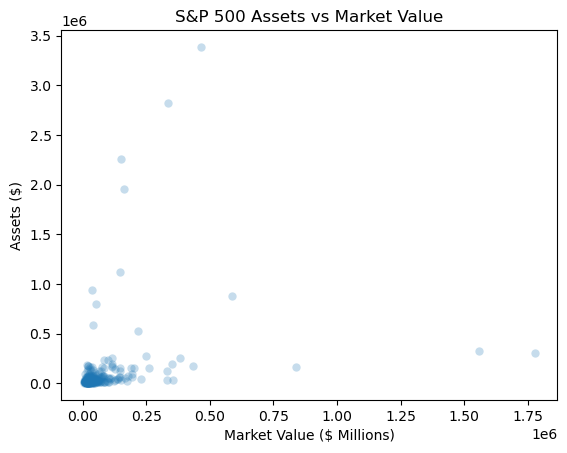

In [45]:
# Scatterplot of Assets ($) vs Market Value ($ Millions)
ae = sns.scatterplot(x ='market', y='assets', data=sp500_df, linewidth=0, alpha=0.25)
ae.set(title="S&P 500 Assets vs Market Value", xlabel='Market Value ($ Millions)', ylabel='Assets ($)')
plt.show()

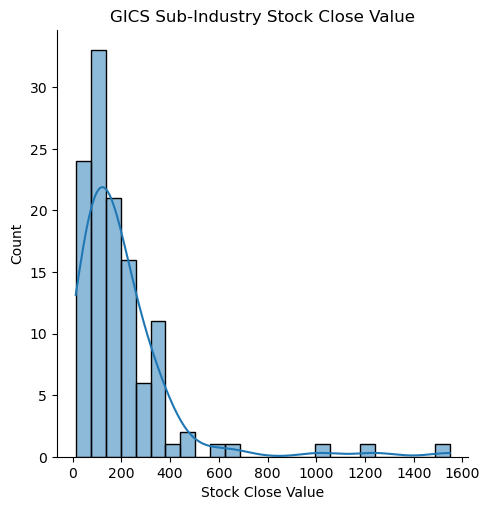

In [28]:
# Group by GICS Sub-Industry
sp500_sub = sp500_df.groupby(sp500_df.gics_sub).mean().reset_index()
# Plot Stock Close Value at the end of 2021
close = sns.displot(data=sp500_sub, x="close", kde=True)
close.set(title="GICS Sub-Industry Stock Close Value", xlabel='Stock Close Value')
plt.show()

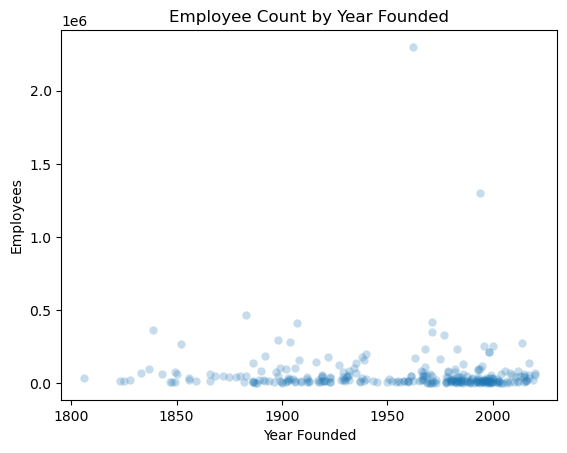

In [46]:
# Show scatterplot of employee count by year founded
emp = sns.scatterplot(x ='founded', y='emp', data=sp500_df, linewidth=0, alpha=0.25)
emp.set(title="Employee Count by Year Founded", xlabel='Year Founded', ylabel='Employees')
plt.show()